<a href="https://colab.research.google.com/github/stefanhuber1993/ColabProteinPrint/blob/main/ColabProteinPrint_OpenSCAD_Colab_v0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive Protein Model Generator v0.1



This colab converts a pdb input file into a number of stl files of peptide backbones and amino acids for direct import into a slicer software for 3D printing.

### Some highlights
* Amino acids are oriented in a standardised way for printing
* Residue ID is printed on the C-alpha hydrogen atom
* Phi and psi angles are encoded directly into the printed model as little notches.

In [1]:
#@title Install dependencies.

%%capture
# First we install openscad
!sudo add-apt-repository ppa:openscad/releases -y
!sudo apt-get update
!sudo apt-get install openscad
# Now we install Viewscad

!pip install viewscad
!pip install gemmi
!pip install nodejs

In [2]:
#@title Imports

%%capture
from google.colab import files
import viewscad
import gemmi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

r = viewscad.Renderer()

In [3]:
#@title Upload your own PDB File
uploaded = files.upload()
fn = list(uploaded.keys())[0]

st = gemmi.read_structure(fn)
st.remove_alternative_conformations()
st.remove_waters()
st.remove_ligands_and_waters()

model = st[0]
residues = model[0] #assuming 1 model with 1 chain

Saving proline2test.pdb to proline2test.pdb


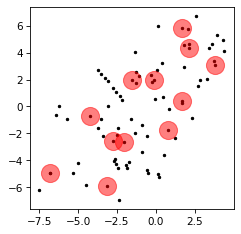

In [9]:
#@title Sanity check: Plot atoms

fig,ax = plt.subplots(dpi=75, figsize=(3.5,3.5))

atoms = np.vstack([[list(atom.pos) for atom in residue] for residue in residues])
backbone = np.array([np.array(list(residue['CA'][0].pos)) for residue in residues])

plt.scatter(*atoms[:,[1,2]].T, color='k', s=5)
plt.scatter(*backbone[:,[1,2]].T, color='red', s=300, alpha=0.5)

In [10]:
#@title Functions for geometry operations

def find_rotation_matrix_vector_to_target(vector, vector_result=[0,0,1]):
    # Normalize the input vector
    vector = vector / np.linalg.norm(vector)
    # Find the rotation axis using cross product
    rotation_axis = np.cross(vector, vector_result)
    # Find the rotation angle using dot product
    rotation_angle = np.arccos(np.dot(vector, vector_result))
    # Create the rotation matrix
    rotation_matrix = rotation_matrix_from_axis_angle(rotation_axis, rotation_angle)
    return rotation_matrix

def rotation_matrix_from_axis_angle(axis, angle):
    # Normalize the rotation axis
    axis = axis / np.linalg.norm(axis)
    # Compute the components of the rotation matrix
    c = np.cos(angle)
    s = np.sin(angle)
    t = 1 - c
    x, y, z = axis
    # Create the rotation matrix
    rotation_matrix = np.array([
        [t*x**2 + c, t*x*y - z*s, t*x*z + y*s],
        [t*x*y + z*s, t*y**2 + c, t*y*z - x*s],
        [t*x*z - y*s, t*y*z + x*s, t*z**2 + c]])
    return rotation_matrix

def rotation_matrix_z(angle):
    cos_theta = np.cos(angle)
    sin_theta = np.sin(angle)

    rotation_matrix = np.array([
        [cos_theta, -sin_theta, 0],
        [sin_theta, cos_theta, 0],
        [0,          0,        1]
    ])
    return rotation_matrix

def find_rotation_angle(vector_a, vector_b):
    # Convert vectors to NumPy arrays
    vector_a = np.array(vector_a)
    vector_b = np.array(vector_b)

    # Calculate dot product
    dot_product = np.dot(vector_a, vector_b)

    # Calculate cross product
    cross_product = np.cross(vector_a, vector_b)

    # Calculate magnitudes of vectors
    magnitude_a = np.linalg.norm(vector_a)
    magnitude_b = np.linalg.norm(vector_b)

    # Calculate the angle in radians
    angle_rad = np.arccos(dot_product / (magnitude_a * magnitude_b))

    # Determine direction of rotation
    #rotation_direction = "Clockwise" if cross_product < 0 else "Counterclockwise"

    return np.sign(cross_product)*angle_rad



# Rotate residue correctly for printing
def rotate_residue(residue):
  # write pandas dataframe!
  positions = [10*np.array(list(atom.pos)) for atom in residue]
  names = [atom.name for atom in residue]
  elements = [atom.element.name for atom in residue]
  aas = [residue.name for r in residue]

  # Rotate CA-CB upright
  residue_df = pd.DataFrame({'name': names, 'pos': positions, 'element':elements, 'aa':aas})
  ca_pos = residue_df[residue_df.name=='CA'].pos.iloc[0]
  if residue.name != 'GLY':
    cb_pos = residue_df[residue_df.name=='CB'].pos.iloc[0]
  else:
    cb_pos = residue_df[residue_df.name=='HA3'].pos.iloc[0]
  ca_cb_vector = cb_pos - ca_pos
  A = find_rotation_matrix_vector_to_target(ca_cb_vector, vector_result=np.array([0,0,1]))
  positions_rotated = np.dot(A, np.vstack(residue_df.pos).T).T                  #rotate CA-CB upright
  positions_rotated -= positions_rotated[np.where(residue_df.name=='CA')[0][0]] #centering

  residue_df = pd.DataFrame({'name': names, 'pos': list(positions_rotated), 'element':elements})

  # Rotate CA-N towards X axis
  ca_pos = residue_df[residue_df.name=='CA'].pos.iloc[0]
  n_pos = residue_df[residue_df.name=='N'].pos.iloc[0]
  ca_n_vector_2d = n_pos[0:2]-ca_pos[0:2]
  angle = find_rotation_angle(ca_n_vector_2d,[0,-1])
  B = rotation_matrix_z(angle)

  # B = rotation_matrix_between_vectors(np.array( [ca_n_vector_2d[0],ca_n_vector_2d[1],0]),
  #                                     np.array( [                1,                0,0])   )

  positions_rotated = np.dot(B, np.vstack(residue_df.pos).T).T

  residue_df = pd.DataFrame({'name': names, 'pos': list(positions_rotated), 'element':elements, 'aa':aas})

  return residue_df




In [13]:
#@title Parameter definition (customizable)

# Parameters here will affect rendering of the stl files
# Phi and psi bonds should have different diameters to differentiate
# Numbers are in millimeters, e.g. phi_bond_diameter=3.5 makes a stick of 3.5 millimeters
# These numbers are multiplied with a scale factor
# (default 0.5, giving a model scale of 1 Angstrom = 0.5 cm)
# pressfit_clearance is the difference of hole and pin size for the phi and psi bonds
# pin_slit_clearance is the size of a gap in the pin for phi and psi bonds
# facet_number is the number of segments to approximate a circle in OpenSCAD
# (default 20, 15-50 are reasonable numbers, affects rendering time)

phi_bond_diameter = 3.5#@param {type:"number"}
psi_bond_diameter = 4.0#@param {type:"number"}
pressfit_clearance = 0.0#@param {type:"number"}
pin_slit_clearance = 0.4#@param {type:"number"}
facet_number = 20#@param {type:"number"}
scale = 0.5#@param {type:"number"}

In [16]:
#@title Make STLs for amino acids

for residue in tqdm(residues):
  seqid = str(residue.seqid)
  if len(seqid) in [1,2]:
    fontsize=8
  else:
    fontsize=6

  # Calculate Ramachandran angles
  prev_res = residues.previous_residue(residue)
  next_res = residues.next_residue(residue)
  phi, psi = gemmi.calculate_phi_psi(prev_res, residue, next_res)

  residue_df = rotate_residue(residue)
  N = residue_df[residue_df.name=='N']
  C = residue_df[residue_df.name=='C']

  stl1 = """
  $fn=$facet_number;
  nr=9;   // nitrogen
  cr=10;  // carbon
  or=9;   // oxygen
  pr=12;  // phosphorus
  hr=7.5; // hydrogen

  module aa(){
      union(){
  """\
  .replace('$facet_number', "%.2f"%facet_number)

  for i,line in residue_df[(residue_df.element!='H') & ([i not in ['C','O','OXT', 'N'] for i in residue_df.name])].iterrows(): #| (residue_df.name=='HA') | (residue_df.name=='HA2')
      if line.aa=='PRO' and line['name']=='CD': #If atom is last atom in proline ring
         n = residue_df[residue_df.name=='N'].iloc[0]
         stl1 += """
          difference(){
              translate([ %.2f,   %.2f,  %.2f]) sphere(   %sr);
              translate([ %.2f,   %.2f,  %.2f]) sphere(   2.0*%sr+%.2f);
          }
          """%(line.pos[0],line.pos[1],line.pos[2],line.element.lower(), n['pos'][0],n['pos'][1],n['pos'][2],n.element.lower(), pressfit_clearance)
      else: # All other atoms in residue
         stl1 += """
          translate([ %.2f,   %.2f,  %.2f]) sphere(   %sr);"""%(line.pos[0],line.pos[1],line.pos[2],line.element.lower())

  stl1 += """
          translate([ -8.94,   5.08,  -3.61]) sphere(   hr);""" # adding Calpha hydrogen atom

  stl1 += """
          rotate(-117,[0,0,1]) rotate(80,[1,0,0]) translate([-0.5,-5,8])
                    linear_extrude(9.1)  text("$text",size=$fontsize,valign="center",halign="center",font="Liberation Sans:style=Bold");
      }
  }
  """.replace('$text', "%s"%seqid)\
     .replace('$fontsize', "%.2f"%fontsize)


  stl2 = """
  module aa2(){
      difference(){
        aa();
        translate([ 0,0,-13]) cylinder( 10,10,20,center=true);

        // Hole for phi bond
        hull(){
        translate([$Nx,$Ny,$Nz]) sphere( $phi_bond_diameter+$pressfit_clearance );
        translate([ 0,0,0]) sphere( $phi_bond_diameter+$pressfit_clearance );
        }

        // Hole for psi bond (cut pin)
        hull(){
        translate([$Cx,$Cy,$Cz])  sphere(  $psi_bond_diameter+$pressfit_clearance);
        translate([ 0,0,0]) sphere( $psi_bond_diameter+$pressfit_clearance );
        }

        // Notch for phi bond
        $nophi rotate(215-$phi,[0,4,1.5])  translate([3,-8,-2.8]) rotate(20,[1,0,0]) cube([14,7,1],center=true); // change first angle

        // Notch for psi bond
        $nopsi rotate(120,[0,0,1])  rotate(62+$psi,[0,4,1.5])  translate([3,-8,-2.8]) rotate(20,[1,0,0])  cube([14,7,1],center=true); //change 2nd angle
      }
  }

  s = $scale;
  scale([s,s,s]){
  aa2();
  }
  """\
  .replace('$Nx',  "%.2f"%N.pos.iloc[0][0])\
  .replace('$Ny',  "%.2f"%N.pos.iloc[0][1])\
  .replace('$Nz',  "%.2f"%N.pos.iloc[0][2])\
  .replace('$Cx',  "%.2f"%C.pos.iloc[0][0])\
  .replace('$Cy',  "%.2f"%C.pos.iloc[0][1])\
  .replace('$Cz',  "%.2f"%C.pos.iloc[0][2])\
  .replace('$phi_bond_diameter', "%.2f"%phi_bond_diameter)\
  .replace('$psi_bond_diameter', "%.2f"%psi_bond_diameter)\
  .replace('$pressfit_clearance', "%.2f"%pressfit_clearance)\
  .replace('$phi', "%.2f"%np.degrees(phi))\
  .replace('$psi', "%.2f"%np.degrees(psi))\
  .replace('$nophi', "//" if np.isnan(phi) else "")\
  .replace('$nopsi', "//" if np.isnan(psi) else "")\
  .replace('$scale', "%.2f"%scale)\


  #print(stl1+stl2)
  r.render(stl1+stl2, outfile='%s_%s.stl'%(seqid,residue.name))


100%|██████████| 12/12 [02:02<00:00, 10.24s/it]


In [93]:
#@title Make STL for trans backbone

stl1 = """
$fn=$facet_number;
nr=9;   // nitrogen
cr=10;  // carbon
or=9;   // oxygen
pr=12;  // phosphorus
hr=7.5;   // hydrogen

// Base backbone
module b(){
      union(){			translate([ 0.00,   0.00,  0.00,])		sphere(   cr);
        translate([ 12.08,   2.20,  0.00,])		sphere(   or);
        translate([ -9.16,   9.71,  0.00,])		sphere(   nr);
        translate([ -18.95,   7.22,  -0.00,])		sphere(   hr);
      }
}

// Addition of sticks for phi and psi bonds
module b2(){
    difference(){
      union(){
          difference(){
            b();
            translate([-5.23,-14.30,0.00 ]) sphere( cr+$pressfit_clearance);
            translate([-5.46,23.72,0.00 ]) sphere( cr+$pressfit_clearance );
          }
          hull(){
            translate([-9.16,9.71,0.00 ])    sphere( $phi_bond_diameter );
            translate([-5.46,23.72,0.00 ]) sphere( $phi_bond_diameter );
          }
          hull(){
            translate([0.00,0.00,0.00 ])    sphere(  $psi_bond_diameter );
            translate([-5.23,-14.30,0.00 ]) sphere(  $psi_bond_diameter );
          }
      }
      translate([ 0,0,-12]) cylinder( 10,50,50,center=true); // flat floor
      translate([ 0,0, 12]) cylinder( 10,50,50,center=true); // flat top
      translate([-5.23,-14.30,0.00 ]) sphere( $psi_bond_diameter+0.01 );
      translate([-2.62,-7.15,0.00 ]) hull(){
            translate([0.00,0.00,0.00 ])    cylinder( 40,$pin_slit_clearance,$pin_slit_clearance,center=true );
            translate([-5.23,-14.30,0.00 ]) cylinder( 40,$pin_slit_clearance,$pin_slit_clearance,center=true );
            }

      translate([1.85,7.00,0.00 ]) hull(){
            translate([-9.16,9.71,0.00 ])    cylinder( 40,$pin_slit_clearance,$pin_slit_clearance,center=true );
            translate([-5.46,23.72,0.00 ]) cylinder( 40,$pin_slit_clearance,$pin_slit_clearance,center=true );
            }

      translate([ -18,19,0])	cube(  [10,10,1.5],center=true); //Phi angle notch
      translate([ 8,-10,0])	cube(  [10,10,1.5],center=true); //Psi angle notch

    }
}

s = $scale;
scale([s,s,s]){
b2();
}

"""\
.replace('$scale', "%.2f"%scale)\
.replace('$phi_bond_diameter', "%.2f"%phi_bond_diameter)\
.replace('$psi_bond_diameter', "%.2f"%psi_bond_diameter)\
.replace('$pin_slit_clearance', "%.2f"%pin_slit_clearance)\
.replace('$pressfit_clearance', "%.2f"%pressfit_clearance)\
.replace('$facet_number', "%.2f"%facet_number)

r.render(stl1, outfile='backbone.stl')

#print(stl1)

In [94]:
#@title Make STL for cis backbone

stl1 = """
$fn=$facet_number;
nr=9;   // nitrogen
cr=10;  // carbon
or=9;   // oxygen
pr=12;  // phosphorus
hr=7.5;   // hydrogen

module b(){
          union(){			translate([ 0.00,   0.00,  0.00,])		sphere(   cr);
			translate([ -11.22,   5.05,  0.00,])		sphere(   or);
			translate([ 0.73,   -13.36,  0.00,])		sphere(   nr);
			translate([ -8.31,   -17.84,  0.64,])		sphere(   hr);
        }
  }

  module b2(){
      difference(){
        union(){
            difference(){
              b();
              translate([12.59,9.06,0.23 ]) sphere( cr+$pressfit_clearance);
              translate([11.89,-22.61,-2.49 ]) sphere( cr+$pressfit_clearance );
            }
            hull(){
              translate([0.00,0.00,0.00 ])    sphere( $phi_bond_diameter );
              translate([12.59,9.06,0.23 ]) sphere( $phi_bond_diameter );
            }
            hull(){
              translate([0.73,-13.36,0.00 ])    sphere(  $psi_bond_diameter );
              translate([11.89,-22.61,-2.49 ]) sphere(  $psi_bond_diameter );
            }
        }
        translate([ 0,0,-12]) cylinder( 10,50,50,center=true); // flat floor
        translate([ 0,0, 12]) cylinder( 10,50,50,center=true); // flat top
        translate([12.59,9.06,0.23 ]) sphere(  $psi_bond_diameter+0.01 );
        translate([6.29,4.53,0.11 ]) hull(){
              translate([0.00,0.00,0.00 ])    cylinder( 40,$pin_slit_clearance,$pin_slit_clearance,center=true );
              translate([12.59,9.06,0.23 ]) cylinder( 40,$pin_slit_clearance,$pin_slit_clearance,center=true );
              }

        translate([5.58,-4.62,-1.24 ]) hull(){
              translate([0.73,-13.36,0.00 ])    cylinder( 40,$pin_slit_clearance,$pin_slit_clearance,center=true );
              translate([11.89,-22.61,-2.49 ]) cylinder( 40,$pin_slit_clearance,$pin_slit_clearance,center=true );
              }

        translate([ 12,-12,0])	cube(  [10,5,1.5],center=true); //Phi angle notch
        translate([ 0,10,0])	cube(  [10,8,1.5],center=true); //Psi angle notch
      }
  }


s = $scale;
scale([s,s,s]){
b2();
}

"""\
.replace('$scale', "%.2f"%scale)\
.replace('$phi_bond_diameter', "%.2f"%phi_bond_diameter)\
.replace('$psi_bond_diameter', "%.2f"%psi_bond_diameter)\
.replace('$pin_slit_clearance', "%.2f"%pin_slit_clearance)\
.replace('$pressfit_clearance', "%.2f"%pressfit_clearance)\
.replace('$facet_number', "%.2f"%facet_number)

r.render(stl1, outfile='backboneCis.stl')

#print(stl1)

In [95]:
#@title Make STL for COO (C-terminal cap)

stl1 = """
$fn=$facet_number;
nr=9;   // nitrogen
cr=10;  // carbon
or=9;   // oxygen
pr=12;  // phosphorus
hr=7.5;   // hydrogen

// Base backbone
module b(){
      union(){			translate([ 0.00,   0.00,  0.00,])		sphere(   cr);
        translate([ 12.08,   2.20,  0.00,])		sphere(   or);
        translate([ -9.16,   9.71,  0.00,])		sphere(   or);
        //translate([ -18.95,   7.22,  -0.00,])		sphere(   hr);
      }
}

// Addition of sticks for phi and psi bonds
module b2(){
    difference(){
      union(){
          difference(){
            b();
            translate([-5.23,-14.30,0.00 ]) sphere( cr+$pressfit_clearance);
            //translate([-5.46,23.72,0.00 ]) sphere( cr+$pressfit_clearance );
          }
          //hull(){
          //  translate([-9.16,9.71,0.00 ])    sphere( $phi_bond_diameter);
          //  translate([-5.46,23.72,0.00 ]) sphere( $phi_bond_diameter );
          //}
          hull(){
            translate([0.00,0.00,0.00 ])    sphere(  $psi_bond_diameter );
            translate([-5.23,-14.30,0.00 ]) sphere(   $psi_bond_diameter );
          }
      }
      translate([ 0,0,-12]) cylinder( 10,50,50,center=true); // flat floor
      translate([ 0,0,12]) cylinder( 10,50,50,center=true); // flat top
      translate([-5.23,-14.30,0.00 ]) sphere( $psi_bond_diameter+0.01 );
      translate([-2.62,-7.15,0.00 ]) hull(){
            translate([0.00,0.00,0.00 ])    cylinder( 40,$pin_slit_clearance,$pin_slit_clearance,center=true );
            translate([-5.23,-14.30,0.00 ]) cylinder( 40,$pin_slit_clearance,$pin_slit_clearance,center=true );
            }

      //translate([1.85,7.00,0.00 ]) hull(){
      //      translate([-9.16,9.71,0.00 ])    cylinder( 40,$pin_slit_clearance,$pin_slit_clearance,center=true );
      //      translate([-5.46,23.72,0.00 ]) cylinder( 40,$pin_slit_clearance,$pin_slit_clearance,center=true );
      //      }

      //translate([ -18,19,0])	cube(  [10,10,1.5],center=true); //Phi angle notch
      //translate([ 8,-10,0])	cube(  [10,10,1.5],center=true); //Psi angle notch

    }
}

s = $scale;
scale([s,s,s]){
b2();
}

"""\
.replace('$scale', "%.2f"%scale)\
.replace('$phi_bond_diameter', "%.2f"%phi_bond_diameter)\
.replace('$psi_bond_diameter', "%.2f"%psi_bond_diameter)\
.replace('$pin_slit_clearance', "%.2f"%pin_slit_clearance)\
.replace('$pressfit_clearance', "%.2f"%pressfit_clearance)\
.replace('$facet_number', "%.2f"%facet_number)

r.render(stl1, outfile='coo.stl')

#print(stl1)


In [15]:
#@title Make STL for NH2 (N-terminal cap)

stl1 = """
$fn=$facet_number;
nr=9;   // nitrogen
cr=10;  // carbon
or=9;   // oxygen
pr=12;  // phosphorus
hr=7.5;   // hydrogen

// Base backbone
module b(){
      union(){			translate([ -5.50,   2.00,  5.00,])		sphere(   hr);
        //translate([ 12.08,   2.20,  0.00,])		sphere(   or);
        translate([ -9.16,   9.71,  0.00,])		sphere(   nr);
        translate([ -18.95,   7.22,  -0.00,])		sphere(   hr);
      }
}

// Addition of sticks for phi and psi bonds
module b2(){
    difference(){
      union(){
          difference(){
            b();
            //translate([-5.23,-14.30,0.00 ]) sphere( cr+$pressfit_clearance);
            translate([-5.46,23.72,0.00 ]) sphere( cr+$pressfit_clearance );
          }
          hull(){
            translate([-9.16,9.71,0.00 ])    sphere( $phi_bond_diameter);
            translate([-5.46,23.72,0.00 ]) sphere($phi_bond_diameter );
          }
          //hull(){
          //  translate([0.00,0.00,0.00 ])    sphere(  $psi_bond_diameter );
          //  translate([-5.23,-14.30,0.00 ]) sphere(   $psi_bond_diameter );
          //}
      }
      translate([ 0,0,-12]) cylinder( 10,50,50,center=true); // flat floor
      //translate([ 0,0,12]) cylinder( 10,50,50,center=true); // flat top
      //translate([-5.23,-14.30,0.00 ]) sphere( $psi_bond_diameter+0.01 );
      //translate([-2.62,-7.15,0.00 ]) hull(){
      //     translate([0.00,0.00,0.00 ])    cylinder( 40,$pin_slit_clearance,$pin_slit_clearance,center=true );
      //     translate([-5.23,-14.30,0.00 ]) cylinder( 40,$pin_slit_clearance,$pin_slit_clearance,center=true );
      //     }

      translate([1.85,7.00,0.00 ]) hull(){
            translate([-9.16,9.71,0.00 ])    cylinder( 40,$pin_slit_clearance,$pin_slit_clearance,center=true );
            translate([-5.46,23.72,0.00 ]) cylinder( 40,$pin_slit_clearance,$pin_slit_clearance,center=true );
            }

      //translate([ -18,19,0])	cube(  [10,10,1.5],center=true); //Phi angle notch
      //translate([ 8,-10,0])	cube(  [10,10,1.5],center=true); //Psi angle notch

    }
}

s = $scale;
scale([s,s,s]){
b2();
}

"""\
.replace('$scale', "%.2f"%scale)\
.replace('$phi_bond_diameter', "%.2f"%phi_bond_diameter)\
.replace('$psi_bond_diameter', "%.2f"%psi_bond_diameter)\
.replace('$pin_slit_clearance', "%.2f"%pin_slit_clearance)\
.replace('$pressfit_clearance', "%.2f"%pressfit_clearance)\
.replace('$facet_number', "%.2f"%facet_number)

r.render(stl1, outfile='nh2.stl')

#print(stl1)



In [97]:
#@title Download everything as a zip
import glob
from zipfile import ZipFile

zippydizipzapfile = ZipFile('combinedSTLs.zip', 'w')

for name in glob.glob('*.stl'):
  zippydizipzapfile.write(name)
zippydizipzapfile.close()

files.download('combinedSTLs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Printing instructions

Stl files can be directly imported into a slicer software (e.g. PrusaSlicer) and are correctly oriented for printing.

Print _n_ amino acids, _n-1_ backbones, 1x nh2.stl and 1x coo.stl. For special cases with cis-peptide bonds there is an extra file.

For backbones, paint-on support can be used to support the pins with minimal material.
For amino acids, full support may need to be created depending on the rotameric state of the amino acid because of strong overhangs.
If first-layer adhesion is a problem with your printer, you may want to use a brim around the amino acid base.

Reasonable settings are: 0% infill, 3 perimeters, 0.2 mm layer height.

## Assembly

1. Pair all amino acids with a backbone (aligning phi angle notches, and a tiny drop of super glue to lock the angle)
2. Assemble pairings from above into a peptide (align psi angle notches, super glue)
3. Cap ends off with amino and carboxy group.

In [99]:
#@title Cleanup

import glob
import os

filenames = glob.glob('*.stl')
for f in filenames:
    os.remove(f)

## Acknowledgements

### OpenSCAD in Google colab
The method to run OpenSCAD in a colab is derived from user _zkilzz_ from this reddit post:
https://www.reddit.com/r/openscad/comments/w4ljxw/running_openscad_on_google_colab_to_make_user/

### DNA model
A similar model of DNA and the public OpenSCAD code of the project (by _mkuiper_) inspired this protein model:
https://www.thingiverse.com/thing:714312/files
